# Milestone 1 Phase 1
Nama: Judan Syamsul Hadad

Batch: FTDS-009

## 1. Perkenalan

Selamat datang. Notebook ini dibuat sebagai pemenuhan penilaian kompetensi dari rangkaian <u>**Full Time Data Science (FTDS) Bootcamp Batch 9**</u> yang diadakan oleh Hacktiv8 dimana penulis atas nama **Judan Syamsul Hadad** dengan handlename **Riezn** merupakan salah satu pesertanya.

Dataset yang digunakan pada notebook ini dapat diunduh [disini](https://www.kaggle.com/datasets/mirichoi0218/insurance). Dataset ini merupakan kumpulan data dari badan sensus Amerika Serikat yang disimulasikan berdasarkan demografi ril penduduk Amerika Serikat. Dataset ini digunakan untuk memprediksi biaya asuransi dari seseorang berdasarkan faktor-faktor yang ada. Berikut faktor yang dimaksud: 

- `age`: age of primary beneficiary
- `sex`: insurance contractor gender, female, male
- `bmi`: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- `children`: Number of children covered by health insurance / Number of dependents
- `smoker`: Smoking
- `region`: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.
- `charges`: Individual medical costs billed by health insurance

### Deployment
Dapat diakses di:
- [Frontend](https://judan-ftds-009-p1m2-fe.herokuapp.com/)
- [Backend](https://judan-ftds-009-p1m2-be.herokuapp.com/predict)

### 1.1. Objective
Pada notebook ini akan dilakukan pembuatan model regresi dengan tahapan berikut:
1. Exploratory Data Analysis (EDA)
2. Data Preprocessing:
    - Data Splitting:
        - Dataset ke inference set dan train-test set
        - Train-test set ke train set dan test set
    - Outliers Handling
    - Missing Values Handling
    - Feature Engineering (Scaling, Encoding)
    - Principal Component Analysis
3. Model Definition:
    - Ridge regression
    - Random forest regression
    - AdaBoost regression
    - XGBoost regression
4. Model Training
    - Cross validation
5. Model Evaluation
    - Pilih satu model terbaik berdasarkan cross validation
    - Hyperparameter tuning pada model terbaik
    - Evaluasi fit terhadap test set
6. Model Saving
    - Pipeline
7. Model Inference
8. Kesimpulan

### 1.2. Problem Statement
Bagaimana model untuk memprediksi biaya asuransi kesehatan seseorang?

## 2. Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
warnings.filterwarnings('ignore')

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

#models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor


#validation and evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.metrics import r2_score

## 3. Data Loading

Definisikan random state dan seed untuk seluruh kode di notebook ini.

In [2]:
random_state = 34
np.random.seed = 34

Set display agar menampilkan seluruh kolom.

In [3]:
pd.set_option('display.max_columns', None)

Load dataset.

In [4]:
data = pd.read_csv('insurance.csv')

Copy dataset.

In [5]:
df = data.copy()

Cek lima data teratas.

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Cek properties dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Ada 1338 baris dan 7 kolom. Ada data kategorik dan numerik. Tidak ditemukan missing value.

Cek jumlah nilai unik di masing-masing kolom.

In [8]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

Cek duplikat pada dataset.

In [9]:
df.duplicated().sum()

1

In [10]:
df[df.duplicated()==True]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


Ada satu duplikat pada dataset.

Cek statistika deskriptif dari dataset.

In [11]:
df.describe(include='all').T.sort_values(by='mean', ascending=False)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
charges,1338.0,NaN,NaN,NaN,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801
age,1338.0,NaN,NaN,NaN,39.207025,14.04996,18.0,27.0,39.0,51.0,64.0
bmi,1338.0,NaN,NaN,NaN,30.663397,6.098187,15.96,26.29625,30.4,34.69375,53.13
children,1338.0,NaN,NaN,NaN,1.094918,1.205493,0.0,0.0,1.0,2.0,5.0
sex,1338,2,male,676,NaN,NaN,NaN,NaN,NaN,NaN,NaN
smoker,1338,2,no,1064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1338,4,southeast,364,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Simpan tipe feature untuk preprocessing pada bab-bab selanjutnya.

In [12]:
num_cols = df.drop(columns='charges').select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

In [13]:
num_cols

['age', 'bmi', 'children']

In [14]:
cat_cols

['sex', 'smoker', 'region']

## 4. Exploratory Data Analysis (EDA)

### 4.1. Pairplot

Cek distribusi data.

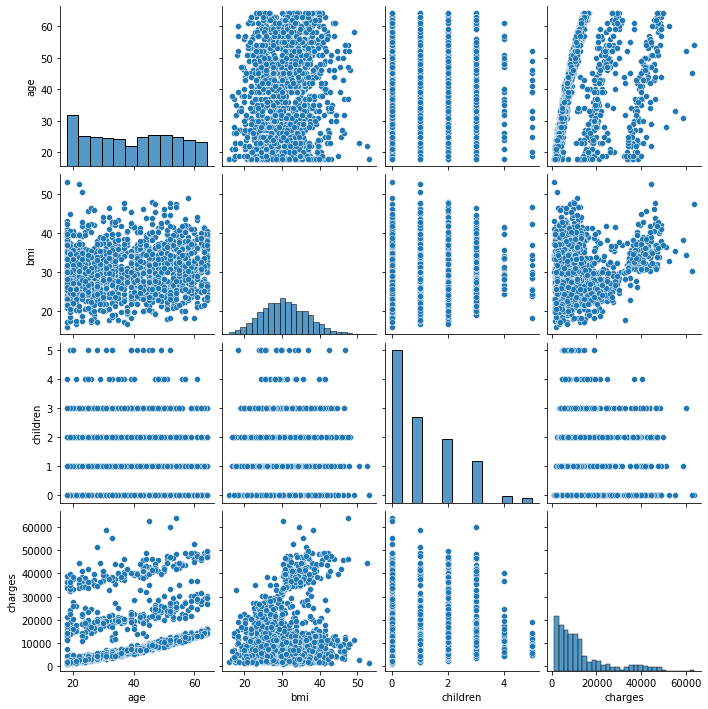

In [15]:
sns.pairplot(df)
plt.show()

Tidak ada feature yang terlihat memiliki korelasi yang kuat.

### 4.2. Boxplot

Cek sebaran data dengan boxplot untuk feature yang skewed.

In [16]:
df.skew()

age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

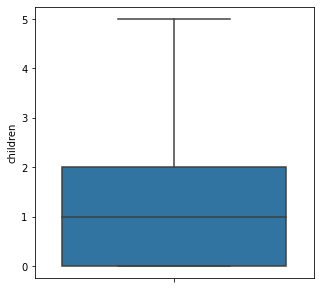

In [17]:
plt.figure(figsize=(5,5))
sns.boxplot(y=df['children'])
plt.show()

Tidak terindikasi ada outlier.

### 4.3. Heatmap

Cek korelasi antar feature numerikal pada dataset.

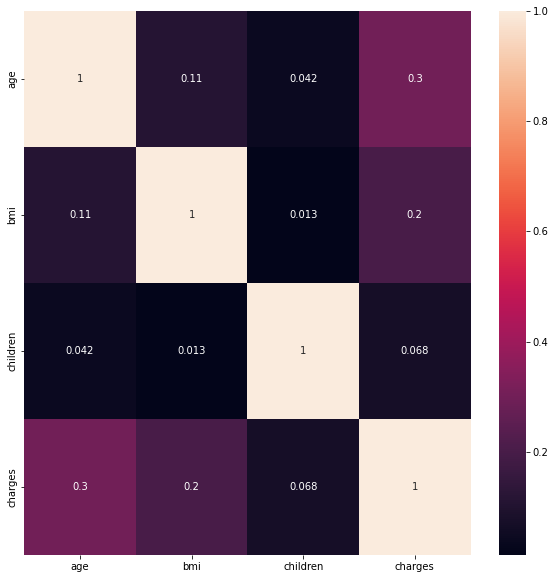

In [18]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(df.corr(),annot=True)

Dari heatmap tidak terlihat feature numerik yang memiliki korelasi di atas 0.7 atau di bawah -0.7.

### 4.4. Barplot

Selanjutnya coba lihat hubungan `charges` terhadap feature kategorik.

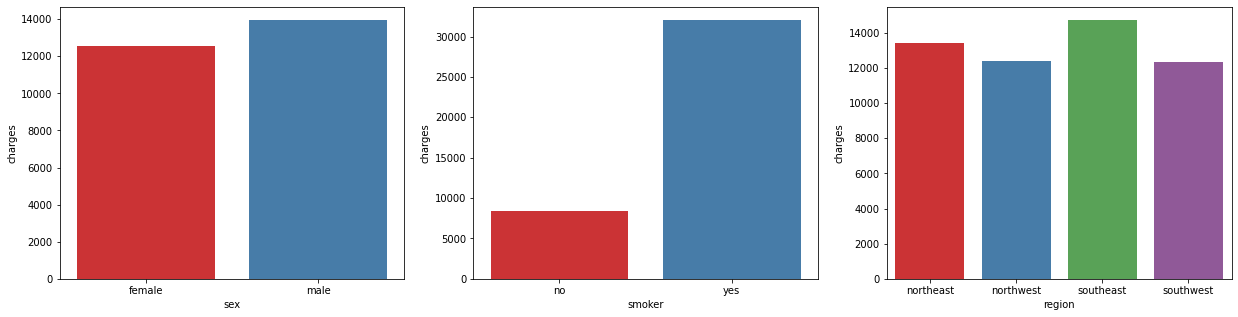

In [19]:
def cat_plot(dataframe,target):
    fig, ax = plt.subplots(ncols=3,figsize=(21,5))
    for i, cat_col in enumerate(cat_cols):
        df_catplot = dataframe[[target,cat_col]].groupby(cat_col).mean().reset_index()
        plt.subplot(1,3,i+1)
        sns.barplot(y=df_catplot[target], x=df_catplot[cat_col], color=df_catplot[cat_col], palette='Set1', ax=ax[i])
        ax[i] = plt.ylabel(target)
        ax[i] = plt.xlabel(cat_col)
    plt.show()
cat_plot(df,'charges')

- `male` memiliki `charges` yang sedikit lebih tinggi dari `female`, kemungkinan karena `male` disini berlaku sebagai kepala keluarga sehingga `charges` untuk keluarganya juga jatuh pada satu orang
- `smoker` memiliki `charges` yang jauh lebih tinggi dari `non-smoker`, hal ini wajar karena seringkali `smoker` memiliki penyakit akibat merokok
- `region` tidak terlihat memiliki perbedaan `charges` yang jauh

## 5. Data Preprocessing

Pada bab ini akan dilakukan pengolahan data sebelum digunakan untuk model.

### 5.1. Data Splitting

Hapus duplikat terlebih dahulu.

In [20]:
df.drop(index=df[df.duplicated()==True].index,inplace=True)

Bagi data menjadi inference, train, validation, dan test set.

Ambil data untuk inferensial dan hapus data tersebut dari dataset yang akan dipisahkan menjadi train dan test set.

In [21]:
#data inference
df_inf = df.dropna().sample(3, random_state=random_state)
df_tt = df.drop(index=df_inf.index)
df_inf

,age,sex,bmi,children,smoker,region,charges
669,40,female,29.810,1,no,southeast,6500.23590
318,44,female,27.645,0,no,northwest,7421.19455
757,47,female,27.830,0,yes,southeast,23065.42070


Deklarasikan feature dan target.

In [22]:
#deklarasi feature dan target
X = df_tt.drop(columns='charges')
y = df_tt['charges']

Bagi data menjadi X (feature) dan y (target) untuk masing-masing train dan test set. Sample test set yang diambil sebanyak 20% dari total data pada dataset.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)

Pisahkan numeric dan categorical feature.

In [24]:
X_train_num = X_train[num_cols]
X_train_cat = X_train[cat_cols]

### 5.2. Outliers Handling

Buat fungsi untuk deteksi outlier.

In [25]:
#deteksi outlier untuk distribusi normal
def find_normal_boundaries(dataframe, variable):
    upper_boundary = dataframe[variable].mean() + 3 * dataframe[variable].std()
    lower_boundary = dataframe[variable].mean() - 3 * dataframe[variable].std()
    return upper_boundary, lower_boundary

#deteksi outlier untuk distribusi skewed
def find_skewed_boundaries(dataframe, variable):
    Q1 = dataframe[variable].quantile(0.25)
    Q3 = dataframe[variable].quantile(0.75)
    IQR = Q3 - Q1
    upper_boundary = Q3 + 1.5 * IQR
    lower_boundary = Q1 - 1.5 * IQR
    return upper_boundary, lower_boundary

def outliersum(dataframe):
    #variable untuk summary
    distribution = []
    skewness = []
    upper_limit = []
    lower_limit = []
    outliers_percent = []
    mean = []
    max = []
    min = []

    #loop untuk summary outlier
    for column in dataframe.columns:

        #cek skewness
        col_skewness = dataframe[column].skew()

        #conditional berdasarkan skewnewss
        if (col_skewness >= -0.5) & (col_skewness <= 0.5):
            col_distribution = 'Normal'
            col_upper_limit, col_lower_limit = find_normal_boundaries(dataframe,column)      
        else:
            col_distribution = 'Skewed'
            col_upper_limit, col_lower_limit = find_skewed_boundaries(dataframe,column)
        
        #cek mean, min,max, dan jumlah outlier
        col_max = dataframe[column].max()
        col_min = dataframe[column].min()
        col_outliers_percent = (len(dataframe[dataframe[column] > col_upper_limit]) +  \
                                len(dataframe[dataframe[column] < col_lower_limit])) / \
                                len(dataframe) * 100
        col_mean = dataframe[column].mean()

        #update summary per loop
        distribution.append(col_distribution)
        skewness.append(col_skewness)
        upper_limit.append(col_upper_limit)
        max.append(col_max)
        min.append(col_min)
        lower_limit.append(col_lower_limit)
        outliers_percent.append(col_outliers_percent)
        mean.append(col_mean)

    #df summary
    outliers_summary = {'distribution_type':distribution,
                        'skewnewss':skewness,
                        'mean': mean,
                        'min':min ,
                        'lower_limit':lower_limit,
                        'upper_limit':upper_limit,
                        'max':max,
                        'outliers_percent':outliers_percent}
    outliers_summary = pd.DataFrame(outliers_summary,index=dataframe.columns)
    outliers_summary = round(outliers_summary.sort_values(by='outliers_percent',ascending=False),2)
    return outliers_summary

Cek outlier pada setiap feature numerik.

In [26]:
outsum = outliersum(X_train_num)
outsum

,distribution_type,skewnewss,mean,min,lower_limit,upper_limit,max,outliers_percent
bmi,Normal,0.27,30.57,15.96,12.49,48.64,53.13,0.37
age,Normal,0.10,38.81,18.00,-3.41,81.03,64.00,0.00
children,Skewed,0.97,1.08,0.00,-3.00,5.00,5.00,0.00


Nilai outlier pada `bmi` masih dalam batas wajar sehingga tidak akan dilakukan handling outlier.

### 5.4. Missing Values Detection

Pada bab Data Loading kita telah mengetahui bahwa tidak ada feature yang memiliki missing value.

In [27]:
X_train.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
dtype: int64

### 5.5. Feature Engineering

#### 5.5.1. Feature Scaling & Principal Component Analysis

Pada tahap ini akan dilakukan scaling lalu reduksi komponen dengan PCA.

In [28]:
#scaling
stdscaler = StandardScaler()
X_train_scaled = stdscaler.fit_transform(X_train_num)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols)

Cek nilai VIF.

In [29]:
#pembuatan dataframe VIF
df_vif = pd.DataFrame()
df_vif["Feature"] = X_train_scaled.columns
  
#hitung dan urutkan VIF dari kecil ke besar
df_vif["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(len(X_train_scaled.columns))]
df_vif.sort_values('VIF',ascending=True,inplace=True)
df_vif.reset_index(drop=True,inplace=True)
df_vif

,Feature,VIF
0,children,1.002474
1,bmi,1.015608
2,age,1.016016


Dari VIF tidak ada kolom yang bisa direduksi. Cek dengan EVR.

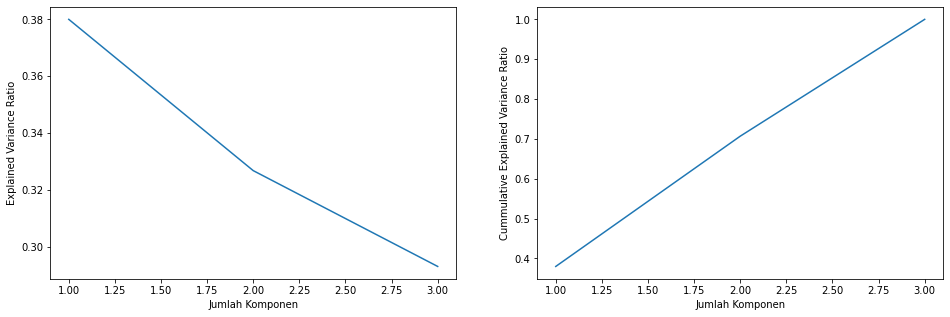

In [30]:
df_evr = PCA().fit(X_train_scaled)
col_length = len(X_train_scaled.columns) + 1

#plot EVR terhadap jumlah feature
fig,ax=plt.subplots(ncols=2, figsize=(16,5))
ax[0].plot(range(1,col_length), df_evr.explained_variance_ratio_)
ax[0].set_xlabel('Jumlah Komponen')
ax[0].set_ylabel('Explained Variance Ratio')

ax[1].plot(range(1,col_length), np.cumsum(df_evr.explained_variance_ratio_))
ax[1].set_xlabel('Jumlah Komponen')
ax[1].set_ylabel('Cummulative Explained Variance Ratio')
plt.show()

Jumlah feature yang dapat mencakup 95% EVR baru didapat di atas 3 feature, maka dari itu tidak akan dilakukan reduksi komponen.

#### 5.5.2. Feature Encoding

Untuk feature kategorik perlu dilakukan encoding. Encoding yang dilakukan akan berbeda-beda tergantung unique value dari feature.

In [31]:
X_train_cat.nunique()

sex       2
smoker    2
region    4
dtype: int64

`sex` dan `smoker` bisa di-encode dengan `LabelEncoder`/`OrdinalEncoder` karena hanya terdiri dari dua value, sedangkan untuk `region` sebaiknya menggunakan `OneHotEncoder` karena tidak ada hirarki pada `region`.

In [32]:
ohe = OneHotEncoder()
oe = OrdinalEncoder()

### 5.6. Preprocessing Pipeline

Keseluruhan preprocessing ini bisa dirangkum menjadi satu pipeline yang akan disebut `prepline` yang dibuat menggunakan ColumnTransformer berikut:

In [33]:
X_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [34]:
prepline = ColumnTransformer([
    ('oe',oe,['sex', 'smoker']),
    ('ohe',ohe,['region']),
    ('scaler',stdscaler,num_cols)
])

In [35]:
X_train_final = prepline.fit_transform(X_train)

## 6. Model Definition

Pada bab ini akan ditentukan model yang digunakan dan hyperparameter yang akan di-tuning jika model tersebut terpilih berdasarkan `Cross Validation`.

Model-model yang digunakan adalah:
- `Ridge`
- `Random Forest Regressor`
- `AdaBoost Regressor`
- `XGBoost Regressor`

Scoring yang digunakan adalah `R2 score`.

### 6.1. Ridge

In [36]:
#base model
ridge = Ridge(random_state=random_state)

#pipeline
pipe_ridge = Pipeline([
    ('prepline',prepline),
    ('ridge',ridge)
])

### 6.2. Random Forest Regressor

In [37]:
#base model
rfr = RandomForestRegressor(random_state=random_state,n_jobs=-1)

#pipeline
pipe_rfr = Pipeline([
    ('prepline',prepline),
    ('rfr',rfr)
])

### 6.3. AdaBoost Regressor

In [38]:
#base model
abr = AdaBoostRegressor(random_state=random_state)

#pipeline
pipe_abr = Pipeline([
    ('prepline',prepline),
    ('abr',abr)
])

### 6.4. XGBoost Regressor

In [39]:
#base model
xgbr = XGBRegressor(random_state=random_state)

#pipeline
pipe_xgbr = Pipeline([
    ('prepline',prepline),
    ('xgbr',xgbr)
])

## 7. Model Training

Pada bab ini akan dilakukan fitting terhadap train set menggunakan masing-masing base model yang telah didefinisikan lalu dilakukan cross validation. Hasil cross validation akan disimpan pada tabel `estimator summary`.

In [40]:
model = ['Ridge','Random Forest Regressor','AdaBoost Regressor','XGBoost Regressor']
estimator = [pipe_ridge, pipe_rfr, pipe_abr, pipe_xgbr]

mean_score = []
stdev_score = []

for est in estimator:
    est.fit(X_train,y_train)
    scores = cross_val_score(est,X_train,y_train,scoring='r2',cv=5,n_jobs=-1)
    
    mean_score.append(np.mean(scores))
    stdev_score.append(np.std(scores))

estimator_summary = pd.DataFrame({'estimator':model,'mean_score':mean_score,'stdev_score':stdev_score})
estimator_summary.sort_values(by='mean_score',ascending=False,inplace=True)
estimator_summary.reset_index(drop=True, inplace=True)

## 8. Model Evaluation

### 8.1. Cross Validation Result

Berikut hasil dari cross validation di bab sebelumnya.

In [41]:
estimator_summary

,estimator,mean_score,stdev_score
0,Random Forest Regressor,0.817435,0.025293
1,AdaBoost Regressor,0.809625,0.019567
2,XGBoost Regressor,0.791823,0.029427
3,Ridge,0.728315,0.021753


Dari hasil cross validation dengan mempertimbangkan standar deviasi, maka model dengan stabilitas yang baik dan score yang tinggi adalah `Random Forest`. Model ini yang akan digunakan untuk seterusnya.

### 8.2. Hyperparameter Tuning

Pengaruh parameter terhadap target pada masing-masing model akan divisualisasikan. Parameter terbaik dari grid search akan digunakan untuk memprediksi test set dan memastikan apakah model underfit, good fit, atau overfit.

Model yang akan di-tuning adalah `Random Forest`. Berikut hyperparameter untuk tuning.

In [42]:
params_rfr = {
    'rfr__n_estimators':np.linspace(50,500,5,dtype=int),
    'rfr__criterion':['squared_error', 'absolute_error', 'poisson'],
    'rfr__max_depth':np.linspace(1,10,5,dtype=int),
    'rfr__max_features':['auto','sqrt','log2']
}

Lakukan tuning dengan GridSearch.

In [43]:
grid_rfr = GridSearchCV(
    pipe_rfr, params_rfr, scoring='r2', cv=5, n_jobs=-1, verbose=1
).fit(X_train, y_train)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


Simpan hasil tuning.

In [44]:
best_params_rfr = grid_rfr.best_params_
best_pipe_rfr = grid_rfr.best_estimator_
df_result_rfr = pd.DataFrame.from_dict(grid_rfr.cv_results_,orient='columns')

Buat fungsi untuk visualisasi pengaruh parameter terhadap R2 score.

In [45]:
#fungsi plot pengaruh parameter
def param_plot(dataframe):
    #param pada model
    params = [col for col in dataframe.columns if 'param_' in col]
    
    
    fig,ax = plt.subplots(1,len(params), figsize=(len(params)*5,5))
    fig.suptitle('Pengaruh Params terhadap Mean R2 Score')
    #initialize while loop
    i = 0
    
    #while loop untuk plot masing-masing param
    while i < len(params):
        ax[i] = plt.subplot(1,len(params),i+1)
        sns.lineplot(data=dataframe,x=params[i],y='mean_test_score',ax=ax[i])
        ax[i] = plt.xticks(rotation=45)
        i += 1
    plt.show()

Berikut visualisasi pengaruh parameter terhadap R2 score.

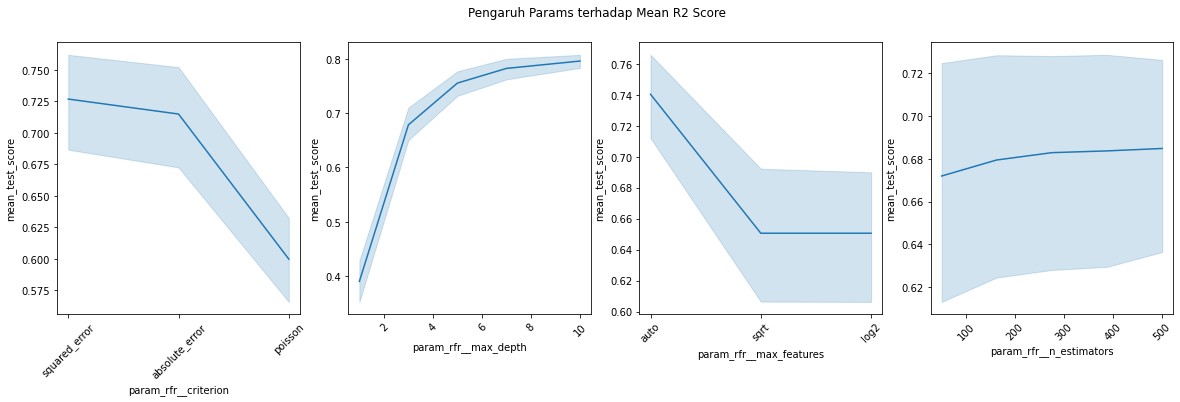

In [46]:
param_plot(df_result_rfr)

- `criterion` dengan mean R2 tertinggi dicapai dengan `mse` atau `squared_error`
- `max_depth` dengan mean R2 tertinggi dicapai di nilai maksimum, tetapi pengaruhnya sudah tidak begitu signifikan setelah `Max Depth` 5
- `max_features` dengan mean R2 tertinggi dicapai dengan `auto`
- `n_estimators` dengan mean R2 tertinggi dicapai pada sekitar 150 estimator, tetapi untuk stabilitasnya tidak terlihat begitu baik di rentang mana pun

Berikut hasil terbaik yang diperoleh dari tuning.

In [47]:
best_params_rfr

{'rfr__criterion': 'squared_error',
 'rfr__max_depth': 5,
 'rfr__max_features': 'auto',
 'rfr__n_estimators': 387}

In [48]:
df_result_rfr[df_result_rfr['params']==best_params_rfr]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfr__criterion,param_rfr__max_depth,param_rfr__max_features,param_rfr__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
33,0.68432,0.083335,0.072213,0.006984,squared_error,5,auto,387,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.882322,0.814802,0.820218,0.817215,0.868317,0.840575,0.028764,1


### 8.3. Evaluate Test Set

Gunakan best pipeline yang telah dibuat untuk memprediksi test set.

In [49]:
print('Train R2 Score:', round(r2_score(y_train,best_pipe_rfr.predict(X_train)),3))
print('Test R2 Score:', round(r2_score(y_test,best_pipe_rfr.predict(X_test)),3))

Train R2 Score: 0.878
Test R2 Score: 0.9


Hasil prediksi dari test set cukup akurat dengan nilai yang sedikit lebih tinggi dibandingkan dengan train set. Model dapat dikatakan `Good Fit`.

## 9. Model Inference

Lakukan inference menggunakan inference set.

In [50]:
df_inf['y-pred'] = best_pipe_rfr.predict(df_inf)
df_inf['y-pred']

669     7044.253544
318     9732.743016
757    27494.903045
Name: y-pred, dtype: float64

Model berhasil memprediksi menggunakan data dari inference set melalui `best_pipe_adaboost`.

In [51]:
X_train.iloc[0]

age                41
sex            female
bmi             36.08
children            1
smoker             no
region      southeast
Name: 729, dtype: object

In [52]:
prepline.get_feature_names_out

<bound method ColumnTransformer.get_feature_names_out of ColumnTransformer(transformers=[('oe', OrdinalEncoder(), ['sex', 'smoker']),
                                ('ohe', OneHotEncoder(), ['region']),
                                ('scaler', StandardScaler(),
                                 ['age', 'bmi', 'children'])])>

In [53]:
final_col = ['Gender (F:0, M:1)', 'Smoker (N:0, Y:1)', 'Northeast', 'Northwest', 'Southeast', 'Southwest', 'Age', 'BMI', 'Children']

In [54]:
X_train_final[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        0.        ,  0.1557613 ,  0.91574854, -0.06435279])

In [55]:
best_params_rfr

{'rfr__criterion': 'squared_error',
 'rfr__max_depth': 5,
 'rfr__max_features': 'auto',
 'rfr__n_estimators': 387}

In [56]:
best_rfr = RandomForestRegressor(n_estimators=387, max_features='auto', max_depth=5, criterion='squared_error', random_state=random_state, n_jobs=-1)

In [57]:
df_train_final = pd.DataFrame(X_train_final, columns=final_col)
df_train_final

,"Gender (F:0, M:1)","Smoker (N:0, Y:1)",Northeast,Northwest,Southeast,Southwest,Age,BMI,Children
0,0.0,0.0,0.0,0.0,1.0,0.0,0.155761,0.915749,-0.064353
1,1.0,0.0,1.0,0.0,0.0,0.0,0.653358,0.035515,1.610389
2,1.0,0.0,1.0,0.0,0.0,0.0,-0.768347,-1.337150,0.773018
3,0.0,0.0,0.0,1.0,0.0,0.0,0.937699,-2.031372,-0.901724
4,0.0,0.0,1.0,0.0,0.0,0.0,-0.910517,-0.153818,2.447760
...,...,...,...,...,...,...,...,...,...
1062,1.0,0.0,0.0,0.0,1.0,0.0,-0.484006,2.651303,0.773018
1063,1.0,0.0,1.0,0.0,0.0,0.0,0.084676,0.587737,-0.064353
1064,0.0,0.0,0.0,1.0,0.0,0.0,-0.768347,-0.706040,1.610389
1065,0.0,0.0,0.0,0.0,1.0,0.0,1.577466,-0.911151,-0.901724


In [58]:
best_rfr.fit(df_train_final,y_train)

RandomForestRegressor(max_depth=5, n_estimators=387, n_jobs=-1, random_state=34)

In [61]:
import shap
X_tfs = shap.kmeans(X_train_final,10)

In [62]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

In [63]:
ex = shap.KernelExplainer(best_rfr.predict, X_tfs)
shap_values = ex.shap_values(df_train_final.iloc[0,:])
shap.force_plot(ex.expected_value, shap_values, df_train_final.iloc[0,:])

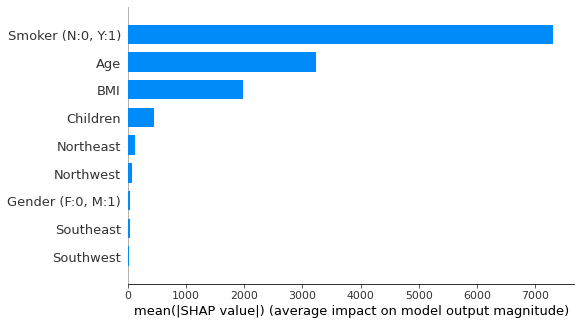

In [71]:
shap_values = shap.TreeExplainer(best_rfr).shap_values(df_train_final)
shap.summary_plot(shap_values, df_train_final, plot_type="bar")

In [64]:
import shap
rf_shap_values = shap.Explainer(best_rfr,X_train_final)

In [65]:
rf_shap_values

## 10. Model Saving

Simpan pipeline yang menghasilkan model terbaik untuk digunakan pada deployment.

In [66]:
with open('model.pkl', 'wb') as f:
    pickle.dump(best_pipe_rfr, f)

## 11. Pengambilan Kesimpulan

Berdasarkan analisis yang telah dilakukan, berikut beberapa hal yang disimpulkan:
1. Feature yang digunakan adalah:
    - `age`
    - `sex`
    - `bmi`
    - `children`
    - `smoker`
    - `region`
2. Model yang terpilih berdasarkan `Cross Validation` adalah `Random Forest Regressor` dengan mean R2 score 0.84 dan standar deviasi 0.029
3. Hyperparameter terbaik yang digunakan adalah:
    - `n_estimators` = 387
    - `max_depth` = 5
    - `max_features` = auto
    - `criterion` = squared_error
4. Model yang dihasilkan `Good Fit` antara train set (R2 score 0.877) dan test set (R2 score 0.9)

In [67]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64